## Problem Set #2

Ari Boyarsky

aboyarsky@uchicago.edu

First, we import requisite packages.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sts
from scipy import integrate

### Problem 1

To begin Problem 1 we read the *incomes.txt* data:

In [19]:
incomes = pd.read_csv("incomes.txt", header = None)

In [20]:
incomes.rename(columns={0: 'Income'}, inplace=True)

In [21]:
incomes.head(5)

,Income
0,51253.497156
1,100630.320241
2,83009.276137
3,82882.106543
4,77338.294839


**(a)** Plot Histogram of *income.txt*

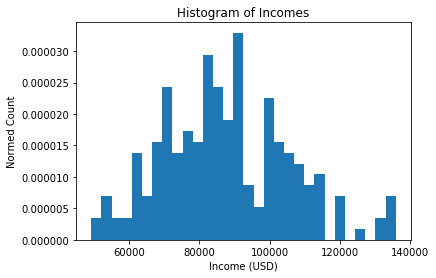

In [22]:
plt.hist(incomes["Income"], bins = 30, normed=True)
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.show()

**(b)** Plot lognormal PDF $f(x\mid \mu = 0.5, \sigma = 0.5)$ and $0 \leq x\leq 150,000$

First we must define encode the log-normal pdf:
$$(LN): f(x|\mu,\sigma)=\frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[log_e(x)-\mu]^2}{2\sigma^2}}$$
$$\forall \; x \in \mathbb{R}_+, \mu \in \mathbb{R}, \sigma \in \mathbb{R}_{++}$$

In [23]:
# PDF of log norm
def log_norm(x, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function simulates a log normal pdf with mean mu 
    and variance sigma^2.  
    --------------------------------------------------------------------
    INPUTS:
    x: vector (array), log normally dist. rand var
    mu: scalar, log normal mean
    sigma: scalar > 0, std. dev. of log normal
    --------------------------------------------------------------------
    RETURNS: value of pdf
    --------------------------------------------------------------------
    '''
    val = ((1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-(((np.log(x)-mu)**2)/(2*(sigma**2)))))
    return val

In [24]:
log_norm(4.3,6,2) # It works!

0.0035220117756071751

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


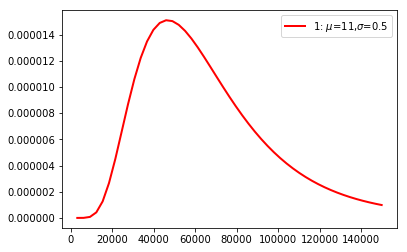

In [25]:
plt.clf()
x = np.linspace(0,150000)
plt.plot(x, log_norm(x, 11, 0.5),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend()
plt.show()

We define a function to retrieve the log-liklihood for future use. We also make a parameter class:

In [26]:
def log_like_LN(x, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function simulates a log likelihood function for a log normal 
    pdf with mean mu and variance sigma^2.  
    --------------------------------------------------------------------
    INPUTS:
    x: vector (array), log normally dist. rand var
    mu: scalar, log normal mean
    sigma: scalar > 0, std. dev. of log normal
    --------------------------------------------------------------------
    RETURNS: log liklihood val
    --------------------------------------------------------------------
    '''
    vals = log_norm(x, mu, sigma)
    log_vals = np.log(vals)
    
    return log_vals.sum()
    

Then the log likelihood of our data is the following:

In [27]:
log_like_LN(incomes["Income"], 11, 0.5)

-2385.856997808559

**Part (c):** Estimate the lognormal parameters and plot this function against the previous PDF from (b) and histogram for (a).

In [28]:
def max_lik(x, parameters):
    def criterion(parameters):
        mu, sigma = parameters
        return -log_like_LN(x, mu, sigma)
    # to ensure sigma > 0, if 0 then divide by zero error
    return minimize(criterion, parameters, method='L-BFGS-B', bounds = ((None, None), (0.0001, None)))

In [29]:
res = max_lik(incomes["Income"], np.array([11, 0.5]))
-res.fun

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


-2285.8999332477283

In [30]:
res.x

array([ 11.49501608,   0.31087915])

Thus, the log liklihood is $-2285.719$ with a mean of $11.459$ and a std. dev. of $0.31$. The variance covariance matrix is as follows:

In [31]:
# Calculate VCV
# method based on lecture notes by Dr. Rick Evans
OffDiagNeg = np.array([[1, -1], [-1, 1]]) 
vcv = res.hess_inv.todense()*OffDiagNeg
print('VCV = ', vcv)

VCV =  [[  4.59466083e-04   6.65458035e-05]
 [  6.65458035e-05   1.71221040e-03]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


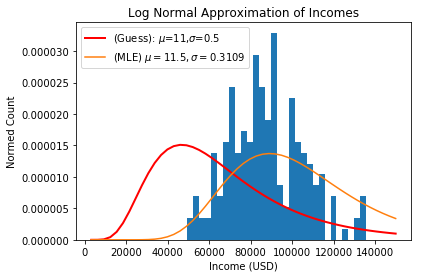

In [32]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Log Normal Approximation of Incomes")
x = np.linspace(0,150000)
plt.plot(x, log_norm(x, 11, 0.5),
         linewidth=2, color='r', label='(Guess): $\mu$=11,$\sigma$=0.5')
plt.plot(x, log_norm(x, res.x[0], res.x[1]), 
         label = "(MLE) $\mu = {}, \sigma = {}$".format(res.x[0].round(2), 
                                                        res.x[1].round(4)))
plt.legend()
plt.show()

**Part (d)** Likelihood ratio test.

In [33]:
h0 = log_like_LN(incomes['Income'], 11, 0.5)
mle = log_like_LN(incomes['Income'], res.x[0], res.x[1])
ratio = 2 * (mle - h0)
p = 1.0 - sts.chi2.cdf(ratio, 2)
print('P-Value = ', p)

P-Value =  0.0


Thus, it is unlikely that the null is true. And so we can reject the null.

**Part (e)** Calculate the probobility of earning more than \$100,000 and probobility of earning less than $75,000.

In [34]:
def cdf_LN(x, mu, sigma):
    return integrate.quad(lambda x: log_norm(x, mu, sigma), 0, x)

print("Probability of earning $100,000 or more:", (1-cdf_LN(100000, res.x[0], res.x[1])[0]))
print("Probability of earning $75,000 or less:", (cdf_LN(75000, res.x[0], res.x[1])[0]))

Probability of earning $100,000 or more: 0.4770301065468413
Probability of earning $75,000 or less: 0.19275917149499458


### Problem 2

In [35]:
sick = pd.read_csv("sick.txt")

In [36]:
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


**Claim 2.1:** We can model use the OLS estimator using MLE with the following log liklihood function:
$$-\frac{n}{2}\log 2\pi - n\log s - \frac{1}{2s^2}\sum^n_i=1(y_i - (\beta_0 + \beta_1x_i+\dots+\beta_nx_{n,i}))^2 \;\; (1)$$

*Proof.*

Recall, the OLS model is as follows:
$$y_i = \beta_0 +\beta_1x_{1,i} + \beta_{2}x_{2,i} + \dots +\beta_nx_{n,i} + \epsilon_i \; s.t. \; \epsilon_i \sim N(0, \sigma^2) \;\; (2)$$ 

Then, if $\epsilon = [\epsilon_1, \dots, \epsilon_n]$ each distributed $N(\mu, \sigma^2)$. Then we can write their pdf as:
$$P(x \; | \; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$
Then notice that we can rewrite our regression function as:
$$\epsilon_i = y_i - \beta_0 -\beta_1x_{1,i} - \beta_{2}x_{2,i} - \dots -\beta_nx_{n,i}$$
$$\epsilon_i + \beta_0 +\beta_1x_{1,i} + \beta_{2}x_{2,i} + \dots +\beta_nx_{n,i} = y_i$$
Then since $\mu = 0$ and we assume that the errors are independent of X, and Y is independent accross observations,
$$\prod^n_{i=1}p(y \; |\; \boldsymbol{X}, \boldsymbol{\beta}, \sigma^2) = \prod^N_{i=1}\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{y_i - (\beta_0 + \beta_1x_{1,i} + \dots + \beta_nx_{n,i})}{2\sigma^2}}$$

Taking the log and simplifying yields:
$$\mathcal{L}(\boldsymbol{\beta}, \sigma) = \log \prod^n_{i=1} p(y \; |\; \boldsymbol{X}, \boldsymbol{\beta}, \sigma^2) = \prod^N_{i=1}\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{y_i - (\beta_0 + \beta_1x_{1,i} + \dots + \beta_nx_{n,i})}{2\sigma^2}}=$$
$$= \sum^n_{i=1}\log p(y \; |\; \boldsymbol{X}, \boldsymbol{\beta}, \sigma^2) \\= -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log\sigma^2 - \frac{1}{2\sigma^2}\sum^n_{i=1}(y_i - (\beta_0 + \beta_1x_{1,i}+\dots+\beta_nx_{1,i}))^2 \;\;\text{Q.E.D.}$$

Now that we have this result we can specify it to our model, specifically,

$$-\frac{n}{2}\log(2\pi)-\frac{n}{2}\log\sigma^2 - \frac{1}{2\sigma^2}\sum^n_{i=1}(y_{\text{sick}, i} - (\beta_0 + \beta_{1}x_{\text{age},i}+\beta_{2}x_{\text{child},i}+\beta_{3}x_{\text{temp},i}))^2 \;\; (3)$$

For convience, we use the matrix form:
$$\log\mathcal{L}(\textbf{X,Y} \;| \;\boldsymbol{\beta}, \sigma) = -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log\sigma^2 - \frac{1}{2\sigma^2}[\textbf{Y}-\textbf{X}\boldsymbol{\beta}]^T[\textbf{Y}-\textbf{X}\boldsymbol{\beta}] \;\;(4)$$

Now that we have the above result we write a function to define it:

In [37]:
def log_like_reg(x, y, beta, sigma):
        '''
        --------------------------------------------------------------------
        This function simulates a log likelihood function for the regression 
        function denoted in (4).
        --------------------------------------------------------------------
        INPUTS:
        x: vector (array) of independent response variables, 
            see x variables in (3)
        y: vector of observations
        beta: The beta parameters of the regression function (3)
        sigma: scalar > 0, std. dev. of error terms in regression
            function (2)
        --------------------------------------------------------------------
        RETURNS: log liklihood value
        --------------------------------------------------------------------
        '''
        N = len(y)
        x = np.concatenate((np.ones((N,1)), x), axis = 1)
        return ((-N/2)*np.log(2*np.pi) - (N/2)*np.log(sigma**2) 
            - (1/(2*(sigma**2)))*((y - x @ beta).T @ (y - x @ beta)))

In [44]:
def MLE(x, y, parameters):
    def criterion(parameters):
        beta = parameters[:4]
        sigma = parameters[4]
        return -log_like_reg(x,y,beta,sigma)
    return minimize(criterion, parameters, method='L-BFGS-B', bounds = ((None, None),(None, None),(None, None),(None, None), (0.00001, None)))

In [45]:
params = np.array([0,0,0,0,1])
res = MLE(sick.iloc[:, 1:].values, sick["sick"].values, params)

In [46]:
res.x

array([ 0.2516445 ,  0.01293344,  0.40050132, -0.00999168,  0.0030177 ])

In [47]:
-res.fun

876.86506400520511

Thus, $\beta_0 = 0.2516445 , \; \beta_1 =0.01293344, \; \beta_2 = 0.40050132, \; \beta_3 = -0.00999168, \; \sigma = 0.0030177, (\sigma^2 \approx 0.009 )$. And log likelihood is $876.86$. The VCV is generated below:

In [48]:
OffDiagNeg = np.array([[1, -1], [-1, 1]]) 
vcv = res.hess_inv.todense()*OffDiagNeg
print('VCV = ', vcv)

ValueError: operands could not be broadcast together with shapes (5,5) (2,2) 

**Part (b)** Likelihood ratio test with $H_0: \beta_0 = 1.0, \; \sigma^2 = 0.01, \beta_1,\beta_2\beta_3 = 0$.

In [42]:
h0 = log_like_reg(sick.iloc[:, 1:].values, sick["sick"].values, [1,0,0,0], 0.1)
mle = log_like_reg(sick.iloc[:, 1:].values, sick["sick"].values, res.x[:4], res.x[4])
ratio = 2 * (mle - h0)
p = 1.0 - sts.chi2.cdf(ratio, 2)
print('P-Value = ', p)

P-Value =  0.0


Thus we can reject $H_0$ since our p-value is very low.

## References

Evans, Rick. "Maximum Likelihood Estimation." Lecture Notes, MACS 30100 (Winter 2018).